Research Links:
* https://www.researchgate.net/publication/258716133_Miniature_Near-Infrared_NIR_Spectrometer_Engine_For_Handheld_Applications

* https://journals.sagepub.com/doi/abs/10.1255/jnirs.1084

In [1]:
import pandas as pd
import ssl
from sklearn.cluster import KMeans
import numpy as np
import json
import random, string
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
tqdm.pandas()
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split,cross_val_score, StratifiedKFold, StratifiedShuffleSplit, GroupKFold
from sklearn.metrics import accuracy_score,confusion_matrix,recall_score,precision_recall_curve, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
#from lightgbm import LGBMClassifier
#import lightgbm as lgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
%matplotlib inline
sns.set(rc = {'figure.figsize':(10,5)})
seed = 42

ssl._create_default_https_context = ssl._create_unverified_context


In [2]:
# Import the dataset
train = pd.read_csv('Data/Updated_Train.csv', index_col=0)
test = pd.read_csv('Data/Updated_Test.csv', index_col=0)
train_trimmed = pd.read_csv('Data/Updated_Train_trimmed.csv', index_col=0)
test_trimmed = pd.read_csv("Data/Updated_Test_trimmed.csv", index_col=0)
spectra_hgb = pd.read_csv('Data/Spectra_hgb.csv', index_col=0).reset_index()
spectra_chol = pd.read_csv('Data/Spectra_chl.csv', index_col=0)
spectra_glu = pd.read_csv('Data/Spectra_gluc.csv', index_col=0).reset_index()
spectra_skinfatblood = pd.read_csv('Data/Spectra_skinfatblood.csv', index_col=0)


In [3]:
train_trimmed.head()

,Reading_ID,absorbance0,absorbance1,absorbance2,absorbance3,absorbance4,absorbance5,absorbance6,absorbance7,absorbance8,...,absorbance143,absorbance144,absorbance145,absorbance146,absorbance147,temperature,humidity,hdl_cholesterol_human,hemoglobin(hgb)_human,cholesterol_ldl_human
0,ID_3SSHI56C,0.561557,0.568417,0.571877,0.570884,0.569032,0.567476,0.565662,0.561901,0.559722,...,1.271104,1.264029,1.250779,1.254856,1.255224,42.51,34.01,ok,ok,ok
1,ID_599OOLZA,0.558420,0.565449,0.569717,0.570999,0.569969,0.568405,0.566628,0.564101,0.559951,...,1.342430,1.339714,1.332805,1.336324,1.342537,44.52,32.09,ok,high,high
2,ID_MVJGPQ75,0.530362,0.538530,0.543128,0.546287,0.547001,0.547120,0.546351,0.544254,0.542802,...,1.332739,1.335550,1.326775,1.336862,1.316860,45.77,24.80,ok,ok,high
3,ID_CK6RF8YV,0.594354,0.599457,0.604529,0.605267,0.606276,0.604895,0.603716,0.600683,0.598087,...,1.263479,1.252612,1.254306,1.247635,1.242321,45.84,36.93,low,ok,high
4,ID_82N6QE6I,0.604401,0.611372,0.614571,0.619713,0.619805,0.622708,0.620036,0.618070,0.616470,...,1.301750,1.288821,1.299768,1.294653,1.294362,38.92,23.88,ok,ok,high


In [5]:
test_trimmed.head()

,Reading_ID,donation_id,absorbance0,absorbance1,absorbance2,absorbance3,absorbance4,absorbance5,absorbance6,absorbance7,...,absorbance142,absorbance143,absorbance144,absorbance145,absorbance146,absorbance147,id,std,temperature,humidity
0,ID_KWUAQLRM,ID_2982,0.600692,0.605104,0.608611,0.608169,0.606985,0.606590,0.603814,0.600409,...,1.249615,1.244618,1.242537,1.238426,1.233983,1.235212,0,0.0027,37.09,27.22
1,ID_FN8SIVJJ,ID_2982,0.601620,0.605895,0.609568,0.610188,0.608635,0.607716,0.606237,0.601746,...,1.256831,1.246188,1.236320,1.242136,1.234657,1.233898,1,0.0027,37.20,27.17
2,ID_CI4TQCHI,ID_2982,0.601226,0.608085,0.611143,0.611085,0.608700,0.608647,0.605048,0.601668,...,1.253063,1.247183,1.245595,1.248910,1.239302,1.236558,2,0.0027,37.30,27.07
3,ID_URJMKNU7,ID_2982,0.606784,0.612443,0.615604,0.616249,0.615097,0.614963,0.611250,0.608559,...,1.257032,1.244043,1.246127,1.238651,1.236244,1.243770,3,0.0027,37.38,26.98
4,ID_HBJH67IS,ID_2982,0.602236,0.607339,0.611220,0.610289,0.609552,0.607212,0.605949,0.603972,...,1.258131,1.245495,1.242633,1.241607,1.243308,1.234993,4,0.0027,37.48,26.89


In [4]:
# # Trim the train and test data of the noise
# abs_to_drop = ['absorbance0', 'absorbance1', 'absorbance2', 'absorbance3',
#        'absorbance4', 'absorbance5', 'absorbance6', 'absorbance7',
#        'absorbance8', 'absorbance9','absorbance10', 'absorbance159', 'absorbance160', 'absorbance161',
#        'absorbance162', 'absorbance163', 'absorbance164', 'absorbance165',
#        'absorbance166', 'absorbance167','absorbance168', 'absorbance169']
# train_trim = train.drop(columns = abs_to_drop, axis=1)
# test_trim = test.drop(columns = abs_to_drop, axis=1)

In [6]:
train_trimmed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13140 entries, 0 to 13139
Columns: 154 entries, Reading_ID to cholesterol_ldl_human
dtypes: float64(150), object(4)
memory usage: 15.5+ MB


In [7]:
test_trimmed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3660 entries, 0 to 3659
Columns: 154 entries, Reading_ID to humidity
dtypes: float64(151), int64(1), object(2)
memory usage: 4.3+ MB


In [8]:
# Check for missing value
print(str(train_trimmed.isnull().sum().sum()) + " missing value in train")
print(str(test_trimmed.isnull().sum().sum()) + " missing value in test")

0 missing value in train
0 missing value in test


There are three target columns in the train dataset, `hdl_cholesterol_human`, `hemoglobin(hgb)_human`, and `cholesterol_ldl_human` - Multi target data. Both train and test have equal number of columns while I expect the test datase to have 3 lesser columns. `donation_id`, `id` and `std` data seems to be in test but not in train data which accounts for the 3 more columns.

The data from each samples are repeated about 60 times at different temperatures and humidity which were said to affect the spectrum data. This might cause overfitting if fed into the model. How do I segment this data? 

### **Exploratory Data Analysis**

In [11]:
train = train_trimmed.copy()
test = test_trimmed.copy()
targets = ['hdl_cholesterol_human', 'cholesterol_ldl_human', 'hemoglobin(hgb)_human']
features = [col for col in train.columns if ("absorbance" in col)] + ["temperature", "humidity"]

In [10]:
#train.drop(columns = targets, axis = 1)

,Reading_ID,absorbance0,absorbance1,absorbance2,absorbance3,absorbance4,absorbance5,absorbance6,absorbance7,absorbance8,...,absorbance140,absorbance141,absorbance142,absorbance143,absorbance144,absorbance145,absorbance146,absorbance147,temperature,humidity
0,ID_3SSHI56C,0.561557,0.568417,0.571877,0.570884,0.569032,0.567476,0.565662,0.561901,0.559722,...,1.285579,1.285488,1.275784,1.271104,1.264029,1.250779,1.254856,1.255224,42.51,34.01
1,ID_599OOLZA,0.558420,0.565449,0.569717,0.570999,0.569969,0.568405,0.566628,0.564101,0.559951,...,1.374128,1.356969,1.352693,1.342430,1.339714,1.332805,1.336324,1.342537,44.52,32.09
2,ID_MVJGPQ75,0.530362,0.538530,0.543128,0.546287,0.547001,0.547120,0.546351,0.544254,0.542802,...,1.354854,1.345476,1.333810,1.332739,1.335550,1.326775,1.336862,1.316860,45.77,24.80
3,ID_CK6RF8YV,0.594354,0.599457,0.604529,0.605267,0.606276,0.604895,0.603716,0.600683,0.598087,...,1.278300,1.268486,1.268407,1.263479,1.252612,1.254306,1.247635,1.242321,45.84,36.93
4,ID_82N6QE6I,0.604401,0.611372,0.614571,0.619713,0.619805,0.622708,0.620036,0.618070,0.616470,...,1.318767,1.316029,1.298889,1.301750,1.288821,1.299768,1.294653,1.294362,38.92,23.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13135,ID_NGPC0DA3,0.563337,0.568932,0.573057,0.575291,0.574014,0.573149,0.570979,0.567632,0.564020,...,1.255005,1.245078,1.245569,1.231796,1.228750,1.238677,1.230577,1.218419,34.79,36.93
13136,ID_XRBUD5U8,0.603612,0.611313,0.614295,0.617476,0.617077,0.618908,0.616631,0.610841,0.604681,...,1.411549,1.415561,1.405296,1.390187,1.384455,1.383000,1.380202,1.383244,43.12,19.14
13137,ID_2M9L5NV2,0.609749,0.617717,0.621270,0.625333,0.626705,0.623455,0.622948,0.618986,0.616963,...,1.399176,1.392111,1.384322,1.376676,1.364141,1.363428,1.366804,1.371499,42.48,43.41
13138,ID_C5V5SD2D,0.542257,0.550854,0.556305,0.558084,0.559439,0.558418,0.554719,0.554852,0.552821,...,1.253335,1.237789,1.228726,1.224605,1.224872,1.217346,1.225207,1.224785,41.86,35.10


In [14]:
train_df = train_copy[features].copy()
test_df = test[features].copy()

The data segmentation makes better sense now with kmeans separation. The data seems to be more separated along humidity ranges.

#### Spectra Data

 -  Spectra Heamoglobin - Oxyhemoglobin

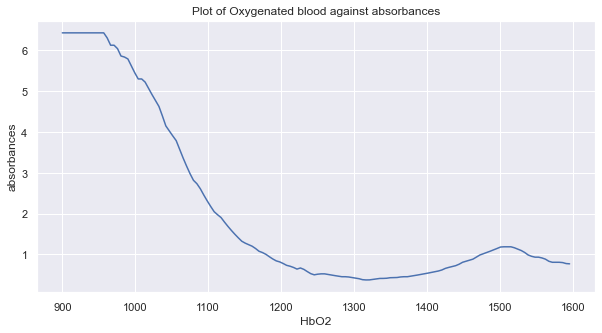

In [15]:
# oxy_hgb = spectra_hgb[['HbO2', 'Unnamed: 4']]
# oxy_hgb = spectra_hgb.rename(columns = {'Unnamed: 4' : 'absorbances'})
# oxy_hgb = oxy_hgb.iloc[1:,3:5]
# oxy_hgb = oxy_hgb.astype(float)
# # Plot the values
# plt.title("Plot of Oxygenated blood against absorbances")
# sns.lineplot(data = oxy_hgb, x = 'HbO2', y = 'absorbances');

 -  Spectra Heamoglobin - Deoxyhemoglobin

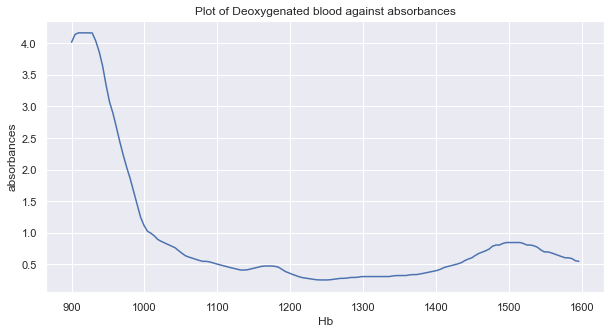

In [16]:
# deoxy_hgb = spectra_hgb[['Hb', 'Unnamed: 1']]
# deoxy_hgb = spectra_hgb.rename(columns = {'Unnamed: 1' : 'absorbances'}).reset_index()
# deoxy_hgb = deoxy_hgb.iloc[1:,1:3]
# deoxy_hgb = deoxy_hgb.astype(float)
# # Plot the values
# plt.title("Plot of Deoxygenated blood against absorbances")
# sns.lineplot(data = deoxy_hgb, x = 'Hb', y = 'absorbances');

In [31]:
# deoxy_hgb['Hgb_high_1'] = list(train[train['hemoglobin(hgb)_human'] == 'high'].iloc[0][0:148].values)
# deoxy_hgb['Hgb_high_2'] = list(train[train['hemoglobin(hgb)_human'] == 'high'].iloc[1000][0:148].values)
# deoxy_hgb['Hgb_low_1'] = list(train[train['hemoglobin(hgb)_human'] == 'low'].iloc[0][0:148].values)
# deoxy_hgb['Hgb_low_2'] = list(train[train['hemoglobin(hgb)_human'] == 'low'].iloc[1000][0:148].values)
# deoxy_hgb['Hgb_ok_1'] = list(train[train['hemoglobin(hgb)_human'] == 'ok'].iloc[0][0:148].values)
# deoxy_hgb['Hgb_ok_2'] = list(train[train['hemoglobin(hgb)_human'] == 'ok'].iloc[1000][0:148].values)
# deoxy_hgb.head()

,Hb,absorbances,Hgb_high_1,Hgb_high_2,Hgb_low_1,Hgb_low_2,Hgb_ok_1,Hgb_ok_2
1,900.000000,4.014902,0.539644,0.543978,0.504699,0.487395,0.520883,0.505315
2,904.733704,4.138519,0.542701,0.543494,0.508213,0.490002,0.528200,0.511985
3,909.467468,4.163159,0.548044,0.539700,0.509817,0.497556,0.529795,0.512434
4,914.201172,4.163159,0.555095,0.555132,0.515906,0.502865,0.537382,0.514565
5,918.934937,4.163159,0.560183,0.557581,0.522573,0.512914,0.540265,0.521053


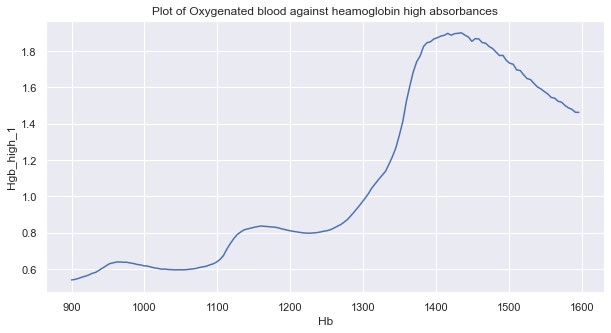

In [18]:
# plt.title("Plot of Oxygenated blood against heamoglobin high absorbances")
# sns.lineplot(data = deoxy_hgb, x = 'Hb', y = 'Hgb_high_1');

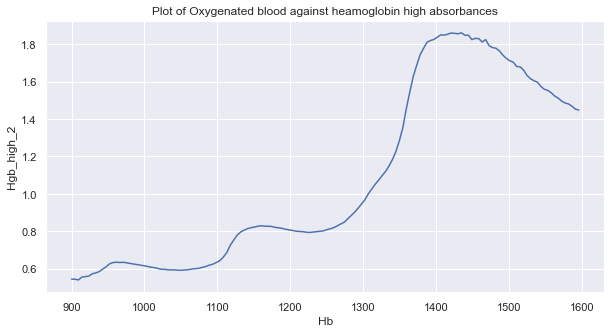

In [32]:
# plt.title("Plot of Oxygenated blood against heamoglobin high absorbances")
# sns.lineplot(data = deoxy_hgb, x = 'Hb', y = 'Hgb_high_2');

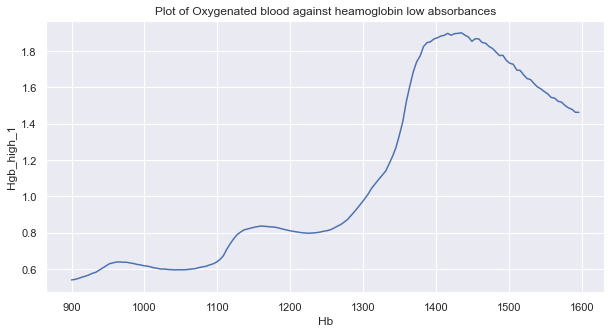

In [33]:
# plt.title("Plot of Oxygenated blood against heamoglobin low absorbances")
# sns.lineplot(data = deoxy_hgb, x = 'Hb', y = 'Hgb_high_1');

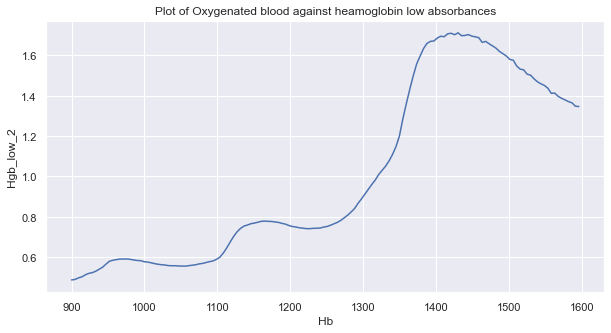

In [34]:
# plt.title("Plot of Oxygenated blood against heamoglobin low absorbances")
# sns.lineplot(data = deoxy_hgb, x = 'Hb', y = 'Hgb_low_2');

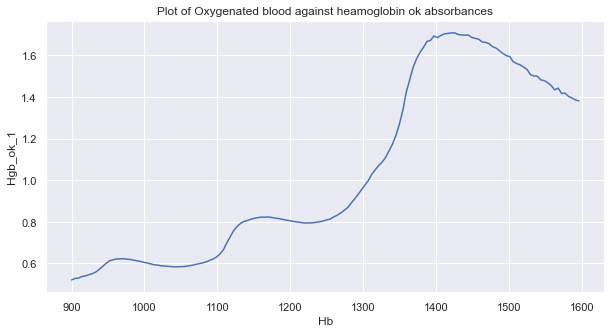

In [35]:
# plt.title("Plot of Oxygenated blood against heamoglobin ok absorbances")
# sns.lineplot(data = deoxy_hgb, x = 'Hb', y = 'Hgb_ok_1');

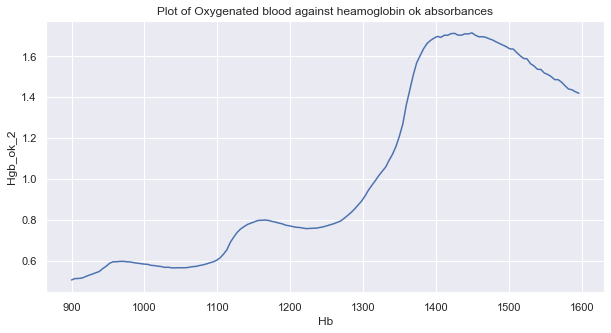

In [36]:
# plt.title("Plot of Oxygenated blood against heamoglobin ok absorbances")
# sns.lineplot(data = deoxy_hgb, x = 'Hb', y = 'Hgb_ok_2');

 -  Spectra Data - Cholesterol

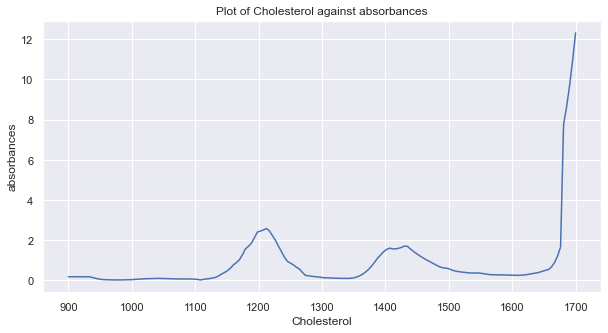

In [19]:
# spectral_chols = spectra_chol.rename(columns = {'Unnamed: 1' : 'absorbances'}).reset_index()
# spectral_chols = spectral_chols.iloc[1:,0:2]
# spectral_chols = spectral_chols.astype(float)
# # Plot the values
# plt.title("Plot of Cholesterol against absorbances")
# sns.lineplot(data = spectral_chols, x = 'Cholesterol', y = 'absorbances');

In [37]:
train.columns

Index(['absorbance0', 'absorbance1', 'absorbance2', 'absorbance3',
       'absorbance4', 'absorbance5', 'absorbance6', 'absorbance7',
       'absorbance8', 'absorbance9',
       ...
       'absorbance169', 'id', 'std', 'temperature', 'humidity',
       'hdl_cholesterol_human', 'hemoglobin(hgb)_human',
       'cholesterol_ldl_human', 'donation_id', 'tag'],
      dtype='object', length=179)

In [44]:
# spectral_chols['chol_high_1'] = list(train[train['hdl_cholesterol_human'] == 'high'].iloc[0][0:170].values)
# spectral_chols['chol_high_2'] = list(train[train['hdl_cholesterol_human'] == 'high'].iloc[1000][0:170].values)
# spectral_chols['chol_low_1'] = list(train[train['hdl_cholesterol_human'] == 'low'].iloc[0][0:170].values)
# spectral_chols['chol_low_2'] = list(train[train['hdl_cholesterol_human'] == 'low'].iloc[1000][0:170].values)
# spectral_chols['chol_ok_1'] = list(train[train['hdl_cholesterol_human'] == 'ok'].iloc[500][0:170].values)
# spectral_chols['chol_ok_2'] = list(train[train['hdl_cholesterol_human'] == 'ok'].iloc[1000][0:170].values)
# spectral_chols.head()

,Cholesterol,absorbances,chol_high_1,chol_high_2,chol_low_1,chol_low_2,chol_ok_1,chol_ok_2
1,900.000000,0.176312,0.428487,0.460853,0.520883,0.494476,0.532470,0.646054
2,904.733704,0.176036,0.434300,0.460763,0.528200,0.488867,0.533690,0.639886
3,909.467468,0.175760,0.440185,0.470332,0.529795,0.496233,0.539646,0.648440
4,914.201172,0.175485,0.446215,0.469511,0.537382,0.504606,0.546352,0.650385
5,918.934937,0.175211,0.453277,0.478151,0.540265,0.508906,0.556648,0.653002


 -  Spectra Heamoglobin - Skin Fat Blood

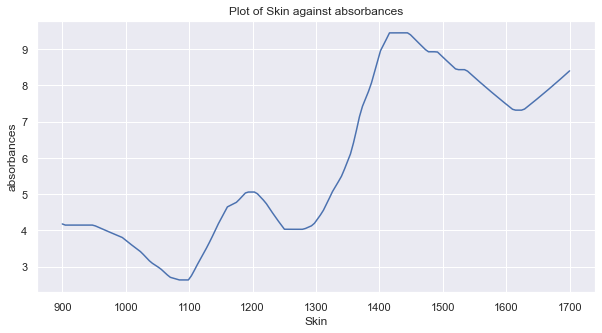

In [20]:
# spectral_skin = spectra_skinfatblood.rename(columns = {'Unnamed: 1' : 'absorbances'}).reset_index()
# spectral_skin = spectral_skin.iloc[1:,0:2]
# spectral_skin = spectral_skin.astype(float)
# # Plot the values
# plt.title("Plot of Skin against absorbances")
# sns.lineplot(data = spectral_skin, x = 'Skin', y = 'absorbances');

In [45]:
# spectral_skin['skin_high_1'] = list(train[train['hdl_cholesterol_human'] == 'high'].iloc[0][0:170].values)
# spectral_skin['skin_high_2'] = list(train[train['hdl_cholesterol_human'] == 'high'].iloc[1000][0:170].values)
# spectral_skin['skin_low_1']= list(train[train['hdl_cholesterol_human'] == 'low'].iloc[0][0:170].values)
# spectral_skin['skin_low_2'] = list(train[train['hdl_cholesterol_human'] == 'low'].iloc[1000][0:170].values)
# spectral_skin['skin_ok_1'] = list(train[train['hdl_cholesterol_human'] == 'ok'].iloc[500][0:170].values)
# spectral_skin['skin_ok_2']= list(train[train['hdl_cholesterol_human'] == 'ok'].iloc[1000][0:170].values)
# spectral_skin.head()

,Skin,absorbances,skin_high_1,skin_high_2,skin_low_1,skin_low_2,skin_ok_1,skin_ok_2
1,900.000000,4.174649,0.428487,0.460853,0.520883,0.494476,0.532470,0.646054
2,904.733704,4.143239,0.434300,0.460763,0.528200,0.488867,0.533690,0.639886
3,909.467468,4.143239,0.440185,0.470332,0.529795,0.496233,0.539646,0.648440
4,914.201172,4.143239,0.446215,0.469511,0.537382,0.504606,0.546352,0.650385
5,918.934937,4.143239,0.453277,0.478151,0.540265,0.508906,0.556648,0.653002


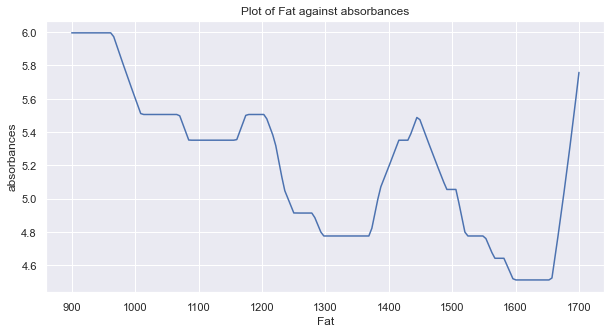

In [21]:
# spectral_fat = spectra_skinfatblood.rename(columns = {'Unnamed: 4' : 'absorbances'}).reset_index()
# spectral_fat = spectral_fat.iloc[1:,3:5]
# spectral_fat = spectral_fat.astype(float)
# # Plot the values
# plt.title("Plot of Fat against absorbances")
# sns.lineplot(data = spectral_fat, x = 'Fat', y = 'absorbances');

In [ ]:
# spectral_skin['skin_high_1'] = list(train[train['hdl_cholesterol_human'] == 'high'].iloc[0][0:170].values)
# spectral_skin['skin_high_2'] = list(train[train['hdl_cholesterol_human'] == 'high'].iloc[1000][0:170].values)
# spectral_skin['skin_low_1']= list(train[train['hdl_cholesterol_human'] == 'low'].iloc[0][0:170].values)
# spectral_skin['skin_low_2'] = list(train[train['hdl_cholesterol_human'] == 'low'].iloc[1000][0:170].values)
# spectral_skin['skin_ok_1'] = list(train[train['hdl_cholesterol_human'] == 'ok'].iloc[500][0:170].values)
# spectral_skin['skin_ok_2']= list(train[train['hdl_cholesterol_human'] == 'ok'].iloc[1000][0:170].values)

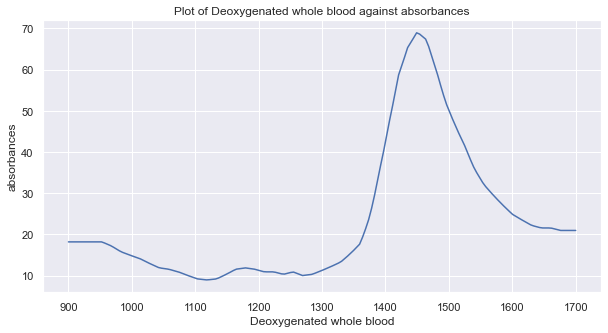

In [22]:
# spectral_blood = spectra_skinfatblood.rename(columns = {'Unnamed: 7' : 'absorbances'}).reset_index()
# spectral_blood = spectral_blood.iloc[1:,6:8]
# spectral_blood = spectral_blood.astype(float)
# # Plot the values
# plt.title("Plot of Deoxygenated whole blood against absorbances")
# sns.lineplot(data = spectral_blood, x = 'Deoxygenated whole blood', y = 'absorbances');

In [23]:
# trimmed_range = list(test_trimmed.columns[2:150])

In [24]:
# wavelengths = list(spectra_glu[1:]['Glucose'])

# absorbance_dict = dict()

# val = 0

# for wave in wavelengths:
    
#     absorbance_dict[f'absorbance{val}'] = wave
    
#     val += 1

In [25]:
# absorbance_dict

{'absorbance0': '900',
 'absorbance1': '904.733704',
 'absorbance2': '909.467468',
 'absorbance3': '914.201172',
 'absorbance4': '918.934937',
 'absorbance5': '923.66864',
 'absorbance6': '928.402344',
 'absorbance7': '933.136108',
 'absorbance8': '937.869812',
 'absorbance9': '942.603577',
 'absorbance10': '947.33728',
 'absorbance11': '952.070984',
 'absorbance12': '956.804749',
 'absorbance13': '961.538452',
 'absorbance14': '966.272217',
 'absorbance15': '971.00592',
 'absorbance16': '975.739624',
 'absorbance17': '980.473389',
 'absorbance18': '985.207092',
 'absorbance19': '989.940857',
 'absorbance20': '994.674561',
 'absorbance21': '999.408264',
 'absorbance22': '1004.142029',
 'absorbance23': '1008.875732',
 'absorbance24': '1013.609497',
 'absorbance25': '1018.343201',
 'absorbance26': '1023.076904',
 'absorbance27': '1027.810669',
 'absorbance28': '1032.544434',
 'absorbance29': '1037.278076',
 'absorbance30': '1042.011841',
 'absorbance31': '1046.745605',
 'absorbance32': '

In [26]:
# #create dictionary to convert absorbance to it's equivalent wavelength range

# trimmed_absorbances = dict()

# val = 11

# for trimmed in trimmed_range:
    
#     trimmed_absorbances[trimmed] = f'absorbance{val}'
    
#     val += 1

In [27]:
# trimmed_absorbances

{'absorbance0': 'absorbance11',
 'absorbance1': 'absorbance12',
 'absorbance2': 'absorbance13',
 'absorbance3': 'absorbance14',
 'absorbance4': 'absorbance15',
 'absorbance5': 'absorbance16',
 'absorbance6': 'absorbance17',
 'absorbance7': 'absorbance18',
 'absorbance8': 'absorbance19',
 'absorbance9': 'absorbance20',
 'absorbance10': 'absorbance21',
 'absorbance11': 'absorbance22',
 'absorbance12': 'absorbance23',
 'absorbance13': 'absorbance24',
 'absorbance14': 'absorbance25',
 'absorbance15': 'absorbance26',
 'absorbance16': 'absorbance27',
 'absorbance17': 'absorbance28',
 'absorbance18': 'absorbance29',
 'absorbance19': 'absorbance30',
 'absorbance20': 'absorbance31',
 'absorbance21': 'absorbance32',
 'absorbance22': 'absorbance33',
 'absorbance23': 'absorbance34',
 'absorbance24': 'absorbance35',
 'absorbance25': 'absorbance36',
 'absorbance26': 'absorbance37',
 'absorbance27': 'absorbance38',
 'absorbance28': 'absorbance39',
 'absorbance29': 'absorbance40',
 'absorbance30': 'ab

In [28]:
# train['tag'] = 'train'
# test['tag'] = 'test'
# all_data = pd.concat([train, test])

In [29]:
# deoxy_hgb

,Hb,absorbances,Hgb_high_1,Hgb_high_2
1,900.000000,4.014902,0.539644,0.543978
2,904.733704,4.138519,0.542701,0.543494
3,909.467468,4.163159,0.548044,0.539700
4,914.201172,4.163159,0.555095,0.555132
5,918.934937,4.163159,0.560183,0.557581
...,...,...,...,...
144,1576.923096,0.603586,1.500220,1.486322
145,1581.656860,0.601905,1.487056,1.481179
146,1586.390503,0.590561,1.479291,1.469348
147,1591.124268,0.555808,1.462813,1.453126
